# Mutual information between Reads and MAGs

This notebook measures the overlap between the reads and the MAGs.

We want to know which MAGs (genomes) are most strongly associated with the latent biological gradients (CPAFs) that emerged from the autoencoder trained on taxonomy + function data.

We use mutual information because:
 - it captures any relationship (linear or non-linear),
 - it’s robust to scale and zero-inflation,
 - and it tells you how much knowing one variable reduces uncertainty about the other.

In [1]:
import os
import sys
import torch

import tensorflow as tf
from tensorflow.keras import layers, models

if not torch.cuda.is_available():
    print("FATAL: Please run this notebook in an environment with CUDA available", file=sys.stderr)
else:
    print("Lets go GPU", file=sys.stderr)

2025-10-20 15:39:03.888657: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Lets go GPU


In [2]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib


In [3]:
sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

training_data, validate_data = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {training_data.shape}")
print(f"Test: {validate_data.shape}")

Train: (101, 1512)
Test: (26, 1512)


Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


## Read the autoencoder model and recreate the latent dimensions

This uses the test and training data from above

In [4]:
outdir = 'cluster_gbrfs'
if not os.path.exists(outdir):
    raise Exception(f"FATAL: Path does not exist: {outdir}")
print(f"Loading the autoencoder from disk.", file=sys.stderr)
autoencoder = models.load_model(os.path.join(outdir, "autoencoder_model"), compile=False)
autoencoder.compile(optimizer='adam', loss='mse')
encoder = models.load_model(os.path.join(outdir, "encoder_model"), compile=False)
decoder = models.load_model(os.path.join(outdir, "decoder_model"), compile=False)
encoder.compile()
decoder.compile()
train_latent = encoder.predict(training_data)
val_latent = encoder.predict(validate_data)
latent_dimensions = encoder.predict(df)

Loading the autoencoder from disk.
2025-10-20 15:39:09.368834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1157 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:41:00.0, compute capability: 7.0


4/4 [==============================] - 0s 2ms/step


## Check by looking at the interesting clusters.

In [5]:
num_features = df.shape[1]  # 1512
num_latent_dims = all_data.shape[1]       # 50 - the number of output layers

corr_matrix = pd.DataFrame(index=df.columns, columns=[f"LD_{i}" for i in range(num_latent_dims)])

for i in range(num_features):
    for j in range(num_latent_dims):
        try:
            corr = np.corrcoef(df.iloc[:, i], all_data[:, j])[0, 1]
            corr_matrix.iloc[i, j] = corr
        except:
            print(f"Error predicting {i} and {j}", file=sys.stderr)
            break

corr_matrix = corr_matrix.astype(float)

# Calculate linkage on the rows (i.e., the features)
Z = linkage(corr_matrix, method='ward', metric='euclidean')

k = 150  # more clusters, smaller groups!
clusters = fcluster(Z, k, criterion='maxclust')  # Each feature gets a cluster ID [1..k]

# create a df with the cluster assignments
cluster_assignments = pd.DataFrame({
    "Feature": corr_matrix.index,  # the feature names
    "Cluster": clusters
})
cluster_assignments.sort_values("Cluster", inplace=True)
grouped = cluster_assignments.groupby("Cluster")
by_cluster = {str(cluster_id): group["Feature"].tolist() for cluster_id, group in grouped}


interesting_cluster = None
interesting_cluster_count = 0
grouped = cluster_assignments.groupby("Cluster")
for cluster_id, group in grouped:
    if group['Feature'].str.contains('Pseudomonas').any():
        if group['Feature'].str.contains('Pseudomonas').sum() > interesting_cluster_count:
            interesting_cluster_count = group['Feature'].str.contains('Pseudomonas').sum()
            interesting_cluster = cluster_id
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---")
        print(group["Feature"].tolist())
        print()
print(f"Interesting cluster is {interesting_cluster}", file=sys.stderr)

--- Cluster 31 : Length 40 ---
['Sulfur transfer pathway CsdAEL', 'Sulfate assimilation related cluster', 'Stress proteins YciF, YciE', 'Two partner secretion pathway (TPS)', 'Type 4 conjugative transfer system, IncI1 type', 'Type III secretion systems', 'Siderophore Pyoverdine', 'Trans-envelope signaling system VreARI in Pseudomonas', 'L-2-amino-4-methoxy-trans-3-butenoic acid synthesis', 'Extracellular matrix proteins (PEL) involved in glucose-rich biofilm formation in Pseudomonas', 'Extracellular matrix proteins (PSL) involved in mannose-rich biofilm formation in Pseudomonas', 'IbrA and IbrB: co-activators of prophage gene expression', 'Rhamnolipids in Pseudomonas', 'Respiratory Systems - Shewanella (updated)', 'Phenazine biosynthesis', 'Periplasmic nitrate reductase EC 1.7.99.4', 'Outer membrane porins in Pseudomonas and Acinetobacter', 'Mycobacterial gene cluster associated with resistance against FAS-II antibiotics', 'Mycobacterial FadE proteins Acyl-CoA dehydrogenase', 'Mycobact

Interesting cluster is 31


## Read the MAG data

In [6]:
mag_metadata = cf_analysis_lib.read_mag_metadata()
mag_metadata

,MAG,Marker lineage,UID,# genomes,# markers,# marker sets,0,1,2,3,4,5+,Completeness,Contamination,Strain heterogeneity,BVBRC Mash Genus,contigs,total size
Bin Id,,,,,,,,,,,,,,,,,,
1,mag_1,k__Bacteria,(UID203),5449,104,58,28,30,31,14,1,0,62.27,31.07,3.8,Unknown,299,12081483
10,mag_10,g__Prevotella,(UID2724),55,567,296,29,508,30,0,0,0,97.22,3.84,70.0,Prevotella,148,3343889
100,mag_100,root,(UID1),5656,56,24,55,1,0,0,0,0,4.17,0.00,0.0,Unknown,2,31122
1001,mag_1001,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,22,85037
10010,mag_10010,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,14,39056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,mag_970,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,3,20839
98,mag_98,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,1,20956
9833,mag_9833,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,7,22789


In [8]:
mag_coverage = cf_analysis_lib.read_mag_coverage()
mag_coverage

,mag_1,mag_2,mag_3,mag_4,mag_5,mag_6,mag_7,mag_8,mag_9,mag_10,...,mag_65224,mag_66866,mag_68519,mag_68728,mag_70256,mag_70473,mag_72938,mag_75531,mag_77836,mag_82829
Sample,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,0.00726,0.01027,0.24020,0.066010,0.002813,0.058595,0.05947,0.00000,0.14690,0.07295,...,5.6680,11.3500,0.9917,5.0065,0.47575,5.563,17.460,0.5397,5.4340,17.98000
1447437_20171212_S,0.00000,0.11850,0.15450,1.395000,0.053300,0.294500,0.00000,0.09932,0.26100,0.15570,...,7.2930,7.9010,0.7893,5.8950,1.23240,5.293,11.820,1.1090,3.1570,0.37425
1128691_20171206_S,0.00000,15.26000,0.00000,0.000000,0.000000,0.000000,4.26900,0.00000,0.15580,0.00000,...,0.0000,5.5220,0.0000,7.7310,0.00000,0.000,9.730,0.0000,4.9690,0.00000
1128691_20171218_S,0.00000,6.09000,0.89995,0.466800,0.000000,0.000000,0.00000,0.00000,1.44300,0.00000,...,8.9850,3.6090,0.0000,2.0625,0.00000,0.000,8.824,0.0000,8.2960,0.00000
1128691_20180116_S,0.00000,20.17000,0.00000,0.893650,0.000000,29.395000,1.74900,0.00000,0.00000,0.00000,...,0.0000,0.0000,0.0000,0.0000,0.00000,0.000,9.599,0.0000,0.0000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,0.00000,0.18990,0.62190,0.033575,0.000000,1.228000,0.00000,0.00000,0.06083,0.06463,...,0.2206,0.9383,2.8330,0.5685,1.31380,1.119,57.250,0.0000,0.3252,0.00000
896213_20180427_S,0.00000,0.00000,0.48190,0.000000,0.661900,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.0000,13.6500,0.0000,11.5110,0.00000,2.560,0.000,0.0000,0.0000,0.00000
913873_20180417_S,0.00000,0.00000,0.62415,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.0000,0.0000,0.0000,0.0000,0.00000,0.000,0.000,0.0000,0.0000,0.00000


In [14]:
latent_dimensions = encoder.predict(df)
latent_dimensions.shape

4/4 [==============================] - 0s 2ms/step


(127, 50)

In [12]:
mag_coverage.shape

(127, 3215)

For Mag Coverage (M): log-transform MAG abundances to stabilise variance.

In [15]:
M_log = np.log10(mag_coverage + 1e-6)

,mag_1,mag_2,mag_3,mag_4,mag_5,mag_6,mag_7,mag_8,mag_9,mag_10,...,mag_65224,mag_66866,mag_68519,mag_68728,mag_70256,mag_70473,mag_72938,mag_75531,mag_77836,mag_82829
Sample,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,-2.139004,-1.988387,-0.619425,-1.180384,-2.550676,-1.232132,-1.225695,-6.000000,-0.832975,-1.136969,...,0.753430,1.054996,-0.003619,0.699534,-0.322620,0.745309,1.242044,-0.267847,0.735120,1.254790
1447437_20171212_S,-6.000000,-0.926278,-0.811069,0.144575,-1.273265,-0.530913,-6.000000,-1.002959,-0.583358,-0.807709,...,0.862906,0.897682,-0.102757,0.770484,0.090752,0.723702,1.072618,0.044932,0.499275,-0.426837
1128691_20171206_S,-6.000000,1.183555,-6.000000,-6.000000,-6.000000,-6.000000,0.630326,-6.000000,-0.807430,-6.000000,...,-6.000000,0.742096,-6.000000,0.888236,-6.000000,-6.000000,0.988113,-6.000000,0.696269,-6.000000
1128691_20171218_S,-6.000000,0.784617,-0.045781,-0.330868,-6.000000,-6.000000,-6.000000,-6.000000,0.159267,-6.000000,...,0.953518,0.557387,-6.000000,0.314394,-6.000000,-6.000000,0.945666,-6.000000,0.918869,-6.000000
1128691_20180116_S,-6.000000,1.304706,-6.000000,-0.048832,-6.000000,1.468273,0.242790,-6.000000,-6.000000,-6.000000,...,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,0.982226,-6.000000,-6.000000,-6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,-6.000000,-0.721473,-0.206279,-1.473971,-6.000000,0.089199,-6.000000,-6.000000,-1.215875,-1.189559,...,-0.656393,-0.027658,0.452247,-0.245269,0.118530,0.048830,1.757775,-6.000000,-0.487848,-6.000000
896213_20180427_S,-6.000000,-6.000000,-0.317042,-6.000000,-0.179207,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,...,-6.000000,1.135133,-6.000000,1.061113,-6.000000,0.408240,-6.000000,-6.000000,-6.000000,-6.000000
913873_20180417_S,-6.000000,-6.000000,-0.204710,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,...,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000


For latent_dimensions (Z): scale each latent dimension to zero mean and unit variance

In [16]:
Z_scaled = StandardScaler().fit_transform(latent_dimensions)

In [17]:
Z_scaled

array([[-0.05334973, -0.30085075, -0.0074415 , ..., -0.10521363,
        -0.58029145,  0.25887445],
       [ 1.5608104 ,  0.3189742 ,  0.4578541 , ...,  0.08133645,
         0.29055977, -0.22340794],
       [ 2.9358509 , -4.7819815 , -0.5797029 , ...,  0.62788236,
        -1.4723996 ,  0.4573481 ],
       ...,
       [-0.49776274,  0.2325675 , -0.26546314, ...,  0.01281575,
         0.07874285, -0.28533858],
       [-0.43241054, -0.21427906, -0.5372996 , ..., -0.10723579,
         0.03812906, -0.7855181 ],
       [ 1.5461296 , -1.8720334 ,  0.32009017, ...,  0.48436412,
        -1.5104334 ,  0.86490625]], dtype=float32)

Now we create a matrix of mutual information:

mi_matrix[j, k] = how much information MAG j shares with latent dimension k.

In [19]:
from sklearn.feature_selection import mutual_info_regression
mi_matrix = np.zeros((M_log.shape[1], Z_scaled.shape[1]))

for k in range(Z_scaled.shape[1]):
    mi_matrix[:, k] = mutual_info_regression(M_log, Z_scaled[:, k], random_state=42)


We convert this to a dataframe and normalise it so that for every LD, the strongest MAG association = 1 and all others fall between 0 and 1.

In [26]:
mi_df = pd.DataFrame(mi_matrix, index=mag_coverage.columns, columns=[f"LD_{i+1}" for i in range(mi_matrix.shape[1])])
mi_norm_df = mi_df.div(mi_df.max(axis=0), axis=1)
mi_norm_df

,LD_1,LD_2,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,LD_9,LD_10,...,LD_41,LD_42,LD_43,LD_44,LD_45,LD_46,LD_47,LD_48,LD_49,LD_50
mag_1,0.000000,0.043525,0.163845,0.021582,0.008014,0.000000,0.000000,0.071087,0.000000,0.033050,...,0.000000,0.001004,0.027313,0.028001,0.000000,0.000000,0.004171,0.000000,0.132638,0.025526
mag_2,0.000000,0.197205,0.100857,0.165387,0.328049,0.451996,0.575145,0.000000,0.062050,0.110022,...,0.303607,0.422958,0.206689,0.088218,0.183117,0.168489,0.331437,0.347517,0.210445,0.050843
mag_3,0.125659,0.510200,0.219636,0.781081,0.655893,0.391286,0.495010,0.763858,0.468897,0.188548,...,0.196767,0.745224,0.790150,0.373337,0.969552,0.358896,0.686636,0.808016,0.611863,0.133519
mag_4,0.346193,0.345025,0.387420,0.180530,0.000000,0.310526,0.202004,0.189828,0.059350,0.127647,...,0.186094,0.034354,0.096002,0.076004,0.132424,0.123321,0.279470,0.701727,0.000000,0.000000
mag_5,0.000000,0.180387,0.106984,0.052028,0.095197,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.107321,0.043412,0.000000,0.034015,0.021601,0.010293,0.032373,0.182598,0.038257,0.006700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mag_70473,0.203357,0.150323,0.132798,0.239435,0.694277,0.309491,0.087648,0.288736,0.050845,0.298644,...,0.245954,0.011471,0.412290,0.209532,0.237853,0.308146,0.098880,0.147671,0.462295,0.096354
mag_72938,0.339618,0.302716,0.008096,0.215882,0.320233,0.106333,0.173218,0.195521,0.000000,0.095000,...,0.289551,0.102610,0.127040,0.036652,0.070634,0.260256,0.020499,0.000000,0.430166,0.037066
mag_75531,0.000000,0.101510,0.134922,0.160188,0.113746,0.036249,0.089972,0.004197,0.063191,0.144364,...,0.148241,0.023110,0.076046,0.071108,0.053130,0.075113,0.000000,0.129217,0.177243,0.000000
mag_77836,0.016307,0.259146,0.172924,0.198354,0.193012,0.125021,0.186042,0.298446,0.000000,0.127974,...,0.399966,0.637075,0.279026,0.000000,0.233718,0.191522,0.356873,0.327628,0.193610,0.000000


In [96]:
mi_norm_df.loc['mag_12', :]

LD_1     0.398145
LD_2     0.270451
LD_3     0.000000
LD_4     0.000000
LD_5     0.177126
LD_6     0.189299
LD_7     0.305136
LD_8     0.031471
LD_9     0.118320
LD_10    0.042625
LD_11    0.058931
LD_12    0.111571
LD_13    0.408834
LD_14    0.658889
LD_15    0.117668
LD_16    0.027928
LD_17    0.357254
LD_18    0.122793
LD_19    0.026132
LD_20    0.130900
LD_21    0.381928
LD_22    0.281753
LD_23    0.103629
LD_24    0.351946
LD_25    0.619161
LD_26    0.186006
LD_27    0.112281
LD_28    0.159759
LD_29    0.286682
LD_30    0.078619
LD_31    0.146746
LD_32    0.367137
LD_33    0.246560
LD_34    0.183664
LD_35    0.444630
LD_36    0.356420
LD_37    0.000000
LD_38    0.297757
LD_39    0.105019
LD_40    0.000000
LD_41    0.039386
LD_42    0.521523
LD_43    0.471671
LD_44    0.108716
LD_45    0.072442
LD_46    0.138720
LD_47    0.150667
LD_48    0.000000
LD_49    0.075188
LD_50    0.046952
Name: mag_12, dtype: float64

In [102]:
top95['LD_14']

['mag_2',
 'mag_12',
 'mag_23',
 'mag_32',
 'mag_51',
 'mag_65',
 'mag_76',
 'mag_79',
 'mag_127',
 'mag_132',
 'mag_275',
 'mag_305',
 'mag_2029',
 'mag_2660',
 'mag_2911',
 'mag_2922',
 'mag_2934',
 'mag_5385',
 'mag_7142',
 'mag_8555',
 'mag_20244',
 'mag_23027',
 'mag_27238',
 'mag_37683',
 'mag_37716',
 'mag_37724',
 'mag_37728',
 'mag_37730',
 'mag_37732',
 'mag_37791',
 'mag_37808',
 'mag_37817',
 'mag_37837',
 'mag_37841',
 'mag_37873',
 'mag_37906',
 'mag_37918',
 'mag_37920',
 'mag_37975',
 'mag_37982',
 'mag_37986',
 'mag_37995',
 'mag_38036',
 'mag_38125',
 'mag_38164',
 'mag_38165',
 'mag_38170',
 'mag_38316',
 'mag_38329',
 'mag_38371',
 'mag_38373',
 'mag_38376',
 'mag_38412',
 'mag_38432',
 'mag_38442',
 'mag_38450',
 'mag_38485',
 'mag_38488',
 'mag_38498',
 'mag_38562',
 'mag_38599',
 'mag_38698',
 'mag_38699',
 'mag_38757',
 'mag_38806',
 'mag_38814',
 'mag_38904',
 'mag_38996',
 'mag_39025',
 'mag_39082',
 'mag_39140',
 'mag_39170',
 'mag_39174',
 'mag_39186',
 'mag

In [103]:
for l in top95:
    if 'mag_12' in top50[l]:
        print(l)

LD_14


Here, we keep the most informative MAGs for each latent dimension

In [97]:
top50 = {}
for k, col in enumerate(mi_norm_df.columns):
    top50[col] = mi_norm_df[col].nlargest(50).index.tolist()

Now we keep every MAG whose MI ≥ 95th percentile for that latent dimension

In [29]:
top95 = {}
for k, col in enumerate(mi_norm_df.columns):
    cutoff = mi_norm_df[col].quantile(0.95)
    top95[col] = mi_norm_df.index[mi_norm_df[col] >= cutoff].tolist()


In [31]:
records = []
for ld in mi_norm_df.columns:
    for mag in mi_norm_df.index:
        records.append({
            "MAG": mag,
            "LatentDim": ld,
            "MI_norm": mi_norm_df.loc[mag, ld]
        })

mi_long = pd.DataFrame.from_records(records)
mi_long[mi_long["MI_norm"] > 0.95]

,MAG,LatentDim,MI_norm
882,mag_38045,LD_1,1.000000
2359,mag_41634,LD_1,0.952192
2874,mag_44342,LD_1,0.983638
6019,mag_43887,LD_2,0.964245
6082,mag_44298,LD_2,1.000000
...,...,...,...
155814,mag_39109,LD_49,1.000000
156118,mag_39879,LD_49,0.971426
156664,mag_41591,LD_49,0.989796
157497,mag_55618,LD_49,0.967882


Identify top latent dimensions for each MAG

Each MAG will have high MI with a small subset of latent dimensions. 

This tells us for each MAG, which latent dimensions it’s most strongly associated with.

In [71]:
top_ld_per_mag = {}
threshold = 0.95  # or any quantile cutoff you chose earlier

for mag, row in mi_norm_df.iterrows():
    top_ld = row[row >= threshold].index.tolist()
    top_ld_per_mag[mag] = top_ld

Text(0, 0.5, 'Number of MAGs')

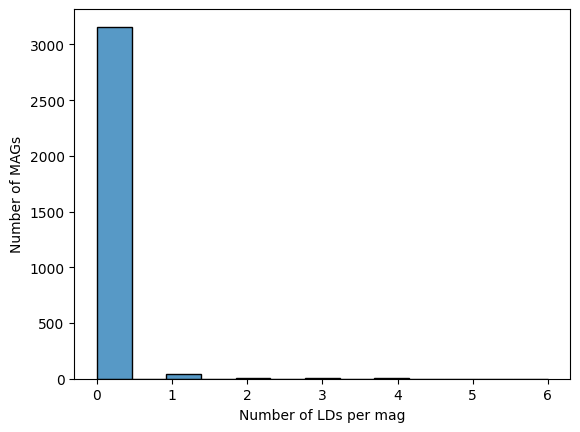

In [72]:
ld_per_mag = [len(top_ld_per_mag[x]) for x in top_ld_per_mag]
g = sns.histplot(ld_per_mag)
g.set_xlabel('Number of LDs per mag')
g.set_ylabel('Number of MAGs')

In [73]:
# is every LD associated with a MAG?
unique =set(y for x in top_ld_per_mag.values() for y in x)
len(unique)

50

From the correlation matrix `corr_matrix` above, we already know which features (taxa + functions) correlate with each latent dimension.

We can assign each latent dimension to clusters that contain its top-correlated features:

In [74]:
ld_to_clusters = {}

for ld in corr_matrix.columns:
    # Find features most strongly correlated with this LD (top 10% absolute correlation)
    threshold = corr_matrix[ld].abs().quantile(0.90)
    top_features = corr_matrix.index[corr_matrix[ld].abs() >= threshold]
    
    # Find which clusters those features belong to
    clusters_for_ld = cluster_assignments.loc[
        cluster_assignments["Feature"].isin(top_features), "Cluster"
    ].unique().tolist()
    
    ld_to_clusters[ld] = clusters_for_ld


## Combine mags and clusters

In [81]:
mag_to_clusters = {}
clusters_to_mags = defaultdict(list)

for mag, lds in top_ld_per_mag.items():
    clusters = set()
    for ld in lds:
        clusters.update(ld_to_clusters.get(ld, []))
    mag_to_clusters[mag] = sorted(clusters)
    for c in clusters:
        clusters_to_mags[str(c)].append(mag)

In [85]:
ic = clusters_to_mags['31']
mag_metadata[mag_metadata['MAG'].isin(ic)]

,MAG,Marker lineage,UID,# genomes,# markers,# marker sets,0,1,2,3,4,5+,Completeness,Contamination,Strain heterogeneity,BVBRC Mash Genus,contigs,total size
Bin Id,,,,,,,,,,,,,,,,,,
19647,mag_19647,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,7,22111
2906,mag_2906,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,1,43429
3,mag_3,o__Actinomycetales,(UID1809),267,400,222,2,386,12,0,0,0,99.40,1.63,50.0,Corynebacterium,48,2019611
3407,mag_3407,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,25,69084
38045,mag_38045,o__Actinomycetales,(UID1530),622,255,150,215,40,0,0,0,0,11.67,0.00,0.0,Rothia,89,231711
3848,mag_3848,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,7,22461
39043,mag_39043,k__Bacteria,(UID203),5449,104,58,102,2,0,0,0,0,1.02,0.00,0.0,Unknown,13,43757
39065,mag_39065,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,15,46275
39804,mag_39804,root,(UID1),5656,56,24,56,0,0,0,0,0,0.00,0.00,0.0,Unknown,7,21421


In [93]:
mag_metadata[(mag_metadata['BVBRC Mash Genus'].astype(str).str.contains('Pseudomo', case=False)) | (mag_metadata['Marker lineage'].astype(str).str.contains('Pseudomo', case=False))]

,MAG,Marker lineage,UID,# genomes,# markers,# marker sets,0,1,2,3,4,5+,Completeness,Contamination,Strain heterogeneity,BVBRC Mash Genus,contigs,total size
Bin Id,,,,,,,,,,,,,,,,,,
12,mag_12,o__Pseudomonadales,(UID4488),185,813,308,4,800,8,1,0,0,99.27,1.6,72.73,Pseudomonas,406,6428243


In [94]:
mag_to_clusters['mag_12']

[]

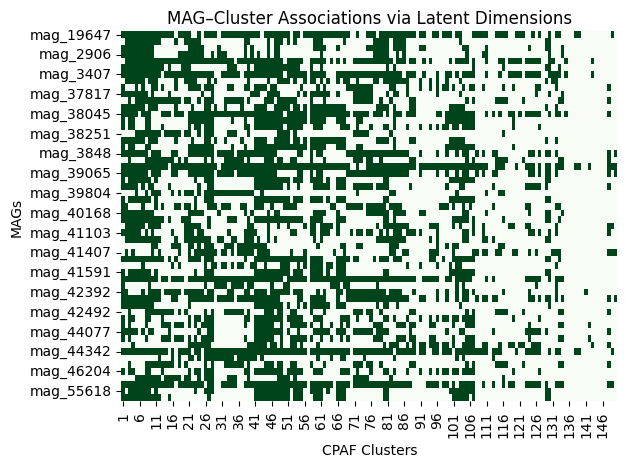

In [115]:
mag_names = sorted(mag_to_clusters.keys())
cluster_ids = sorted(cluster_assignments["Cluster"].unique())
assoc = pd.DataFrame(0, index=mag_names, columns=cluster_ids)

for mag, clusts in mag_to_clusters.items():
    assoc.loc[mag, clusts] = 1

# drop empty rows
assoc = assoc[assoc.sum(axis=1) > 0]
# drop empty columns
# assoc = assoc.loc[:, assoc.sum(axis=0) > 0]

sns.heatmap(assoc, cmap="Greens", cbar=False)
plt.xlabel("CPAF Clusters")
plt.ylabel("MAGs")
plt.title("MAG–Cluster Associations via Latent Dimensions")
plt.show()

In [116]:
assoc.shape

(56, 150)

In [117]:
assoc

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
mag_19647,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
mag_23210,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
mag_27852,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
mag_2906,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
mag_3,0,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
mag_3023,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
mag_3407,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
mag_37804,0,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
mag_37811,1,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
mag_37817,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


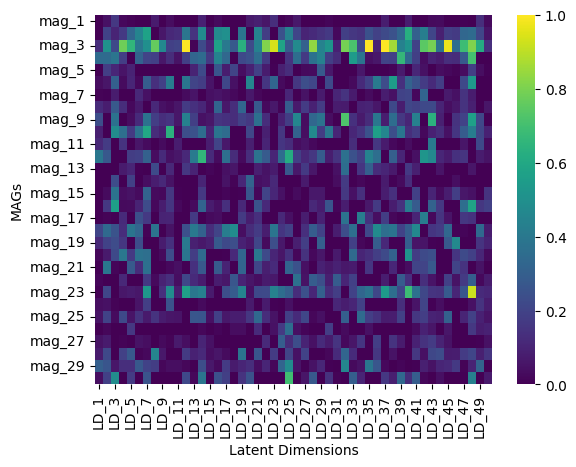

In [35]:
sns.heatmap(mi_norm_df.iloc[:30, :50], cmap="viridis")  # first 50 (all) latent dimensions and first 30 mags
plt.xlabel("Latent Dimensions")
plt.ylabel("MAGs")
plt.show()

Summarise how many unique MAGs are strongly linked across multiple latent dimensions (i.e. overlap network summary)

The MAGs which are across many latent dimensions are the hub MAGs — ones that co-vary with several latent features (i.e. potentially generalist or integrator taxa).

In [36]:
# Flatten all selected MAGs across latent dims
all_selected = [mag for mags in top95.values() for mag in mags]

# Count in how many latent dimensions each MAG appears
mag_counts = Counter(all_selected)

# Convert to DataFrame
hub_df = pd.DataFrame.from_dict(mag_counts, orient="index", columns=["Count_in_LatentDims"])
hub_df.index.name = "MAG"
hub_df.sort_values("Count_in_LatentDims", ascending=False, inplace=True)
hub_df.head(10)

,Count_in_LatentDims
MAG,
mag_19647,27
mag_3,27
mag_39043,26
mag_38045,25
mag_3407,25
mag_41634,25
mag_43729,23
mag_44342,22
mag_42397,22


What is the distribution of latent dimensions and MAGs.

It turns out that most MAGs are only associated with 1 or 2 LDs

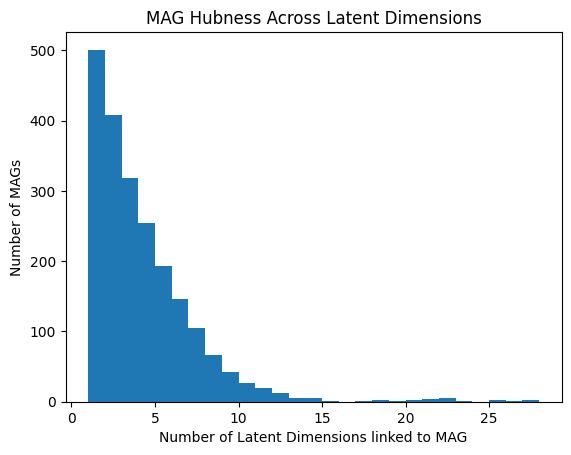

In [38]:
plt.hist(hub_df["Count_in_LatentDims"], bins=range(1, hub_df["Count_in_LatentDims"].max()+2))
plt.xlabel("Number of Latent Dimensions linked to MAG")
plt.ylabel("Number of MAGs")
plt.title("MAG Hubness Across Latent Dimensions")
plt.show()

This correlated heatmap shows whether certain groups of latent dimensions share overlapping MAGs — great for identifying modules of related CPAFs.

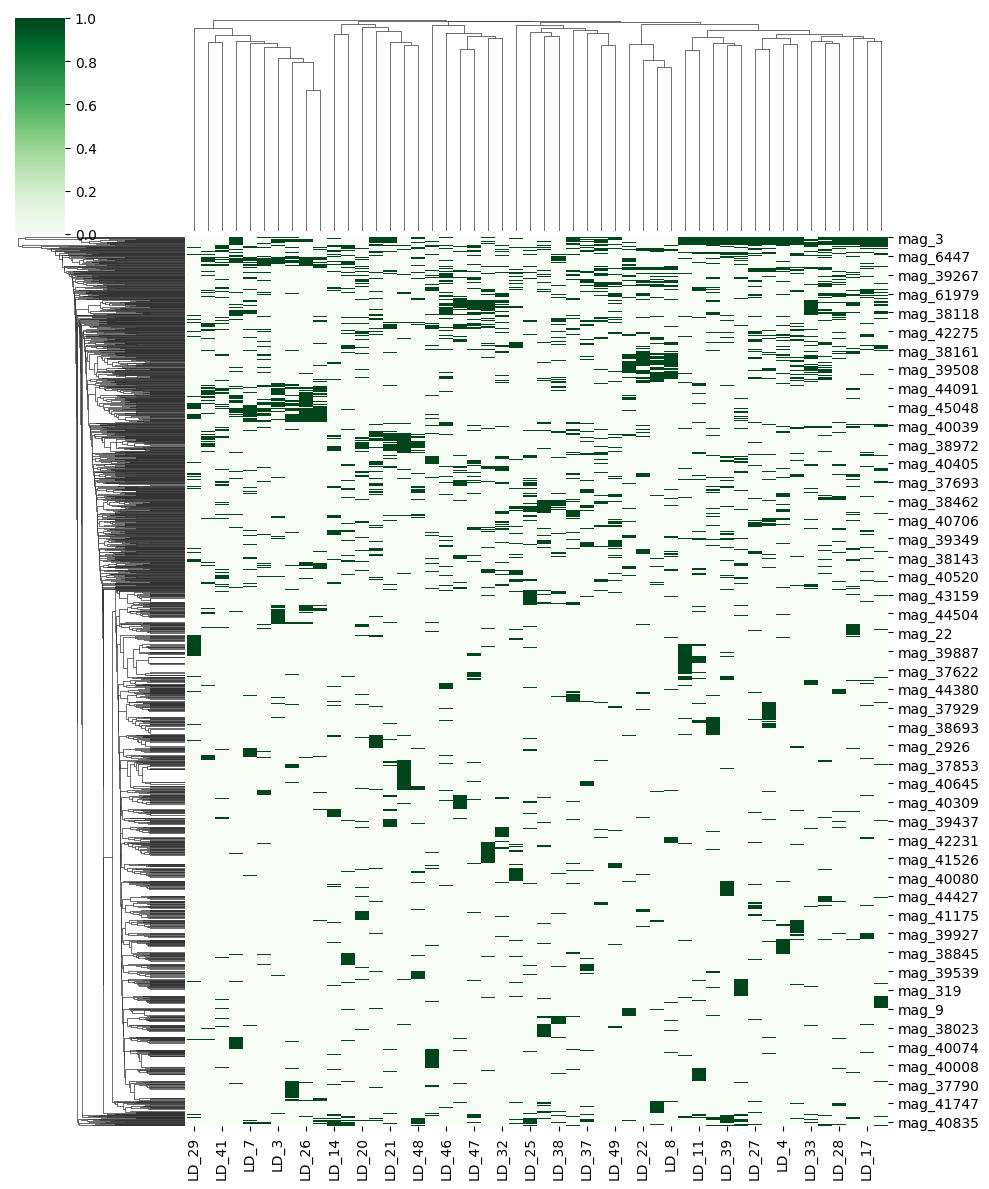

In [39]:
latent_names = list(top95.keys())
mag_names = list(hub_df.index)

# Initialize binary association matrix
assoc = pd.DataFrame(0, index=mag_names, columns=latent_names)

for ld, mags in top95.items():
    assoc.loc[assoc.index.isin(mags), ld] = 1
sns.clustermap(assoc, cmap="Greens", figsize=(10, 12))
plt.show()